# Import needed libraries
To make things work ensure that you have this libraries installed.

In [19]:
# imports
import os
import numpy as np
import splitfolders
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [20]:
class Dataset:
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, image_size: Tuple[int, int] = (224,224), batch_size: int = 8):
        self.path = path
        self.labels = [name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name))]

        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        if split:
            self.__split_folder()
            
        self.__generate()
        
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        train_paths = list(paths.list_images(self.train))
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        val_paths = list(paths.list_images(self.val))
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        test_paths = list(paths.list_images(self.test))
        self.test_len = len(test_paths)
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .cache()
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [21]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [29]:
def build_model(height: int = 224, width: int = 224, channels: int = 3):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Reshape((width, height * channels)))
    model.add(Bidirectional(GRU(256)))
    model.add(Dense(256, activation='elu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# Short-Time Fourier Transform

In [33]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)

Copying files: 4995 files [00:11, 429.91 files/s]


In [35]:
model = build_model()

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.1741 - loss: 2.1956 - val_accuracy: 0.3003 - val_loss: 1.8923
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3137 - loss: 1.8621 - val_accuracy: 0.3180 - val_loss: 1.7183
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3387 - loss: 1.7285 - val_accuracy: 0.3431 - val_loss: 1.6692
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3575 - loss: 1.6729 - val_accuracy: 0.3821 - val_loss: 1.6140
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3901 - loss: 1.6223 - val_accuracy: 0.4170 - val_loss: 1.5716
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4139 - loss: 1.5739 - val_accuracy: 0.4351 - val_loss: 1.5412
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4361 - loss: 1.5225 - val_accuracy: 0.4589 - val_loss: 1.4995
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4617 - loss: 1.4601 - val_accu

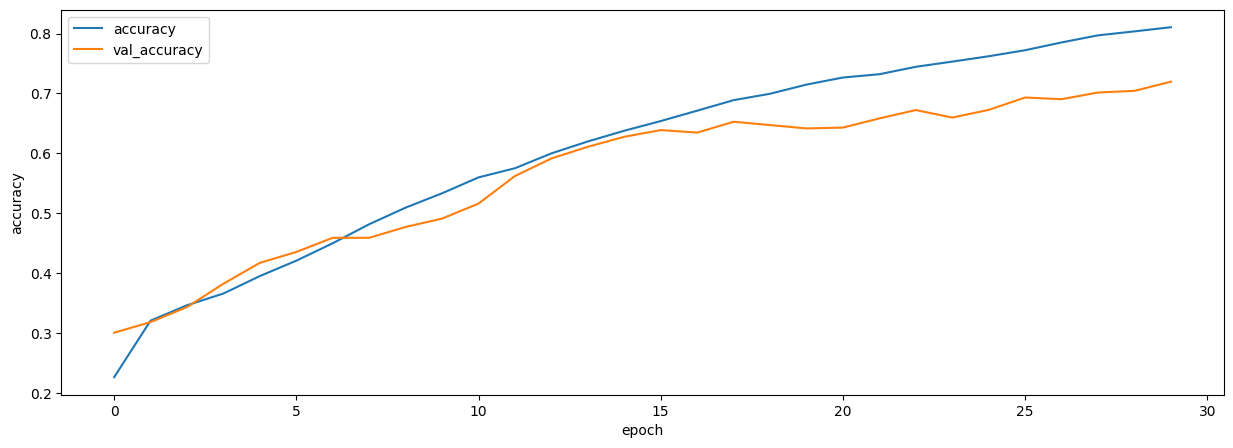

In [36]:
plot_history(history, metric='accuracy')

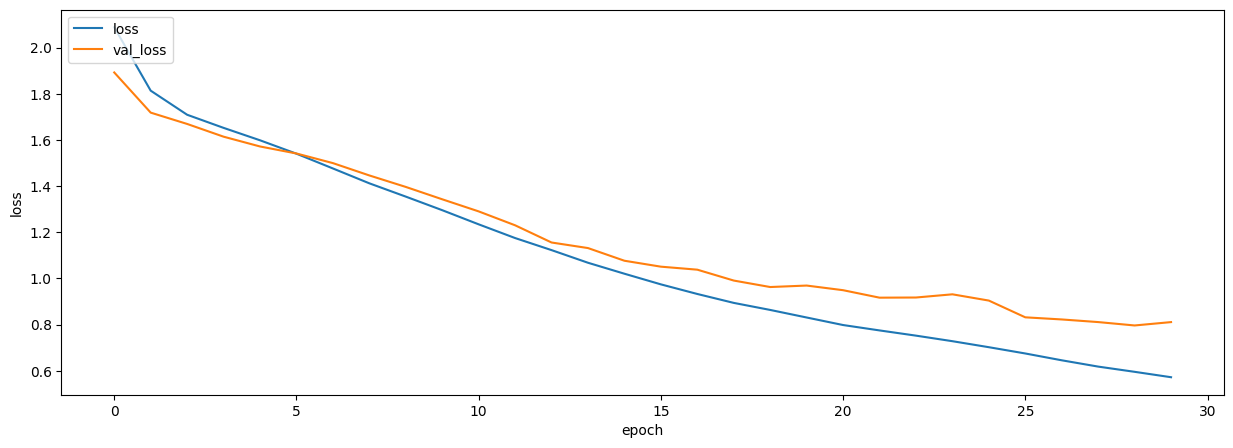

In [37]:
plot_history(history, metric='loss')

In [38]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7437 - loss: 0.7928
Accuracy: 0.7146666646003723
Loss: 0.8462721705436707


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


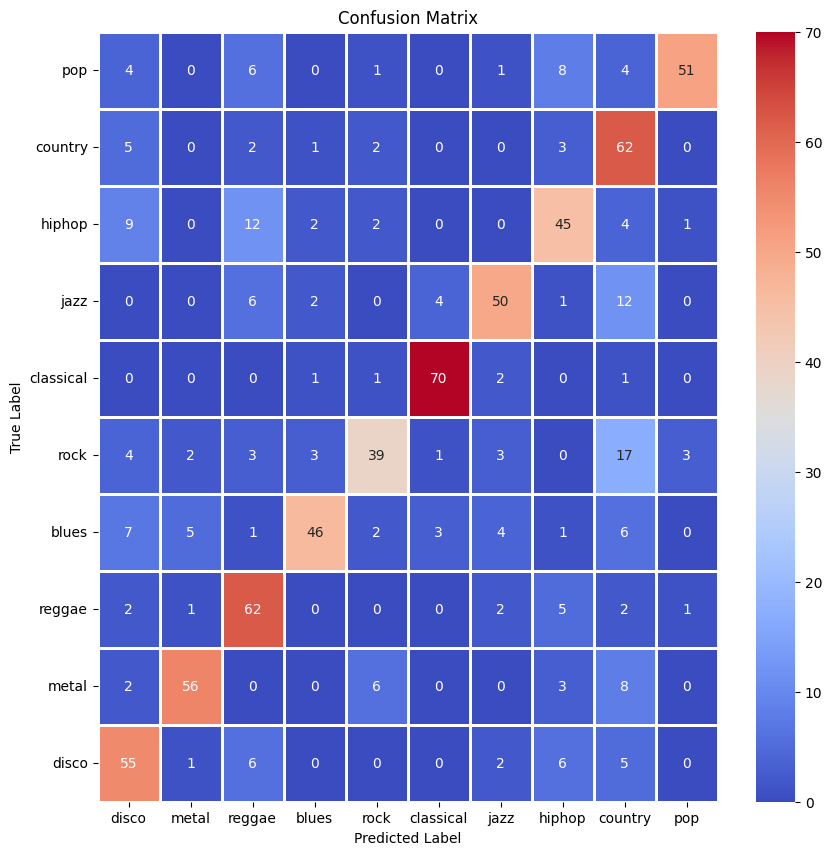

              precision    recall  f1-score   support

           0       0.62      0.73      0.67        75
           1       0.86      0.75      0.80        75
           2       0.63      0.83      0.72        75
           3       0.84      0.61      0.71        75
           4       0.74      0.52      0.61        75
           5       0.90      0.93      0.92        75
           6       0.78      0.67      0.72        75
           7       0.62      0.60      0.61        75
           8       0.51      0.83      0.63        75
           9       0.91      0.68      0.78        75

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.72       750
weighted avg       0.74      0.71      0.72       750



In [39]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel Spectogram

In [40]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)

Copying files: 4995 files [00:43, 114.18 files/s]


In [41]:
model = build_model()

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2129 - loss: 2.1369 - val_accuracy: 0.3084 - val_loss: 1.8299
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3287 - loss: 1.8064 - val_accuracy: 0.3612 - val_loss: 1.6883
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3730 - loss: 1.6730 - val_accuracy: 0.3933 - val_loss: 1.5767
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4248 - loss: 1.5736 - val_accuracy: 0.4226 - val_loss: 1.4948
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4475 - loss: 1.5019 - val_accuracy: 0.4421 - val_loss: 1.4474
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4683 - loss: 1.4534 - val_accuracy: 0.4616 - val_loss: 1.4237
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4783 - loss: 1.4169 - val_accuracy: 0.4826 - val_loss: 1.3884
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4964 - loss: 1.3690 - val_acc

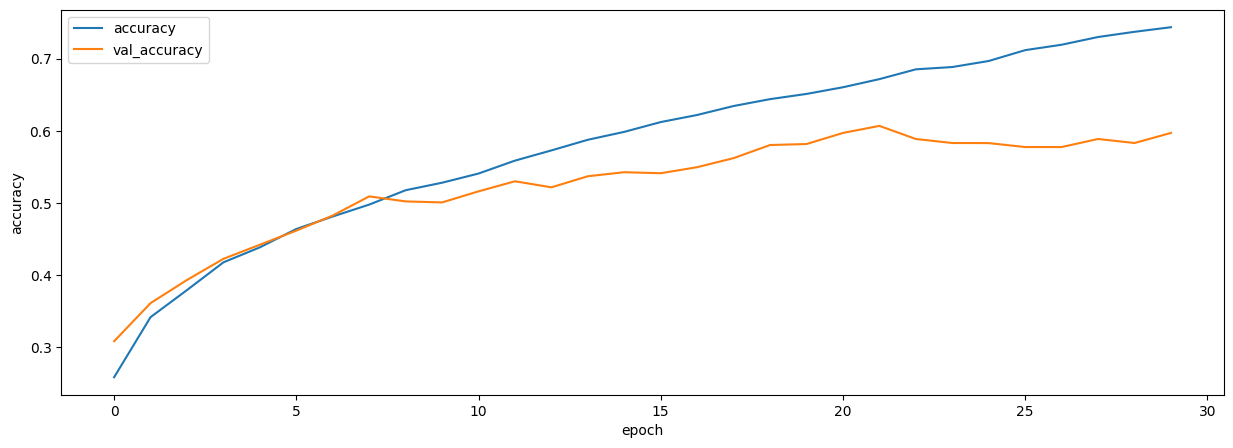

In [42]:
plot_history(history, metric='accuracy')

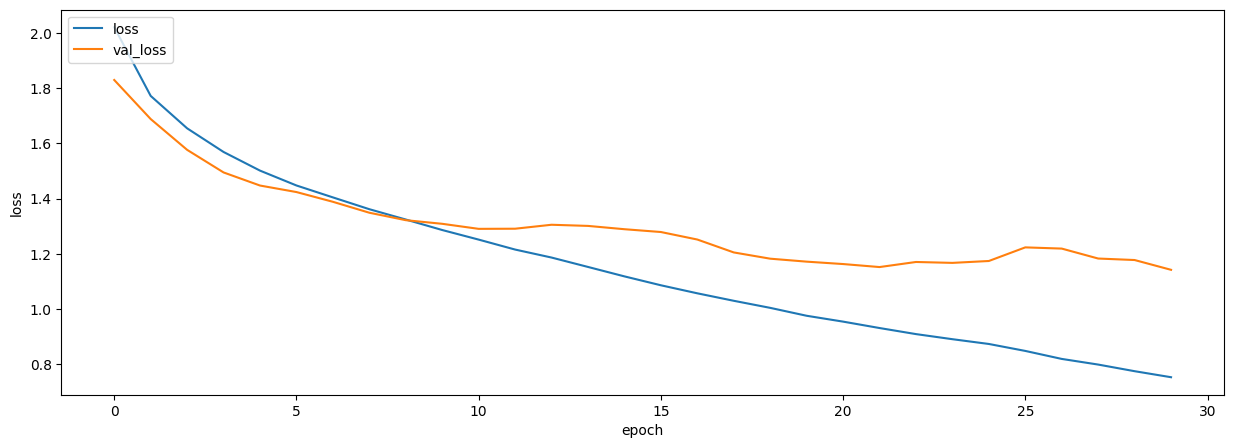

In [43]:
plot_history(history, metric='loss')

In [44]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6017 - loss: 1.1328
Accuracy: 0.5920000076293945
Loss: 1.1120434999465942


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


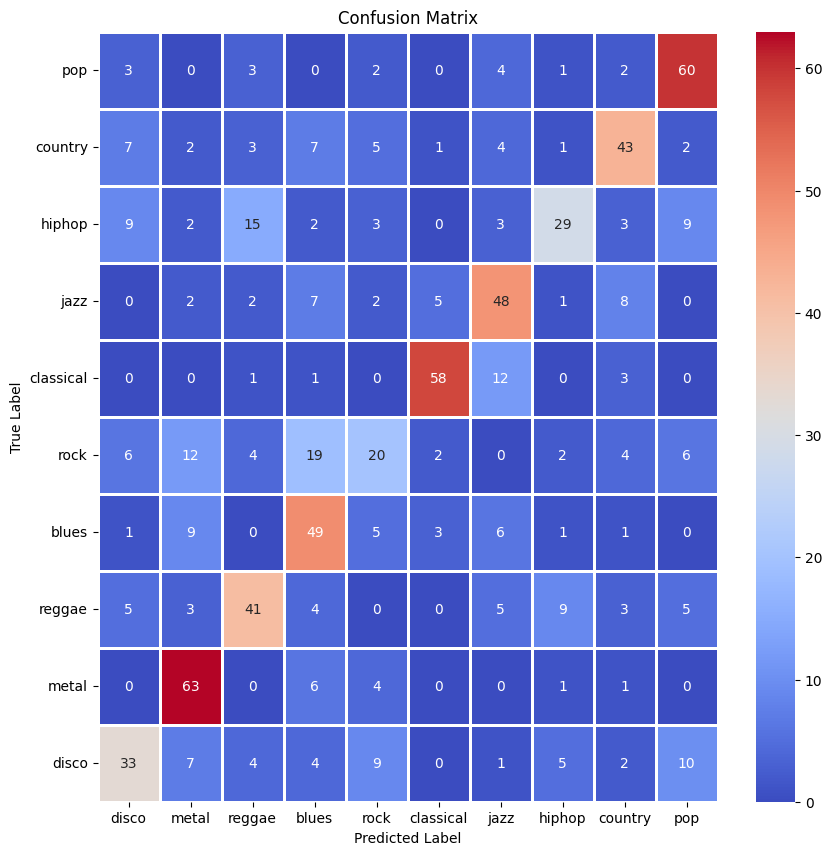

              precision    recall  f1-score   support

           0       0.52      0.44      0.47        75
           1       0.63      0.84      0.72        75
           2       0.56      0.55      0.55        75
           3       0.49      0.65      0.56        75
           4       0.40      0.27      0.32        75
           5       0.84      0.77      0.81        75
           6       0.58      0.64      0.61        75
           7       0.58      0.39      0.46        75
           8       0.61      0.57      0.59        75
           9       0.65      0.80      0.72        75

    accuracy                           0.59       750
   macro avg       0.59      0.59      0.58       750
weighted avg       0.59      0.59      0.58       750



In [45]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))